# CARNIVAL

CARNIVAL (CAusal Reasoning for Network identification using Integer VALue programming) is a method for the identification of upstream reguatory signalling pathways from downstream gene expression (GEX). Applications of CARNIVAL include the identification of drug’s modes of action and of deregulated processes in diseases (even if the molecular targets remain unknown) by deciphering the alterations of main signalling pathways as well as alternative pathways and off-target effects.

<center style="margin:25px">
    <img src="/_static/carnival-abstract.png" alt="CARNIVAL abstract" style="width: 100%; max-width:800px; margin-bottom:10px;" onerror="this.onerror=null; this.src='https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/carnival_graphical_abstract.png';">
    <br>
    <font size="-1">
        <b>Figure 1:</b> Liu A., Trairatphisan P., Gjerga E. et al. From expression footprints to causal pathways: contextualizing large signaling networks with CARNIVAL npj Systems Biology and Applications volume 5, Article number: 40 (2019) (equal contributions).
    </font>
</center>

The aim of the CARNIVAL pipeline is to identify a subset of interactions from a prior knowledge network that represent potential regulated pathways linking known or potential targets of perturbation towards active transcription factors derived from GEX data. The pipeline includes a number improved functionalities comparing to the original version and consists of the following processes:

- Transcription factors’ (TFs) activities and pathway scores from gene expressions can be inferred with our in-house tools (Dorothea, CollecTRI).
- TFs’ activities and signed directed protein-protein interaction networks with or without the provided target of perturbations and pathway scores are then used to construct an optimization problem with CORNETO.
- CORNETO is used to solve the optimization problem with any of the supported solvers (CPLEX, GUROBI, SCIPY, etc), which identifies the sub-network topology with minimised fitting error and model size.



The original version of CARNIVAL was implemented in R and CPLEX. The new re-implementationo of CARNIVAL in CORNETO support a wide variety of solvers thanks to the support of both CVXPY and PICOS. It also has more flexibility since the problem is symbolically defined, and can be modified through the CORNETO API after creating the CARNIVAL problem. This gives user extra flexibility to modify the problem or to use CORNETO as a building block for other optimization problems. 


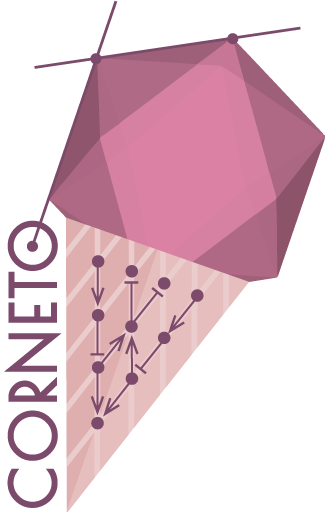

In [1]:
import corneto as cn
import numpy as np
cn.info()

## A toy example

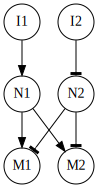

In [2]:
G = cn.Graph.from_sif_tuples(
    [
        ("I1", 1, "N1"),  # I1 activates N1
        ("N1", 1, "M1"),  # N1 activates M1
        ("N1", 1, "M2"),  # N1 activaes M2
        ("I2", -1, "N2"),  # I2 inhibits N2
        ("N2", -1, "M2"),  # N2 inhibits M2
        ("N2", -1, "M1"),  # N2 inhibits M1
    ]
)
G.plot()

In [3]:
from corneto.methods import runVanillaCarnival

# These are the measurements (e.g. TF activity from Decoupler).
# Positive values correspond to up-regulation and negative values
# with down-regulation. The bigger the absolute value is,
# the bigger the importance is
measurements = {"M1": 1, "M2": 1}

# Perturbations are the upstream nodes were the signal originates on,
# for example, ligands or receptors.
perturbations = {"I1": 1, "I2": 1}

# We run the `standard` carnival problem. This interface is similar
# to the old R function https://saezlab.github.io/CARNIVAL/reference/runVanillaCarnival.html
P, Gf = runVanillaCarnival(perturbations, measurements, G, betaWeight=0.1)

(CORNETO) May 21 01:01:41 PM - INFO    : 2/2 inputs mapped to the graph
(CORNETO) May 21 01:01:41 PM - INFO    : 2/2 outputs mapped to the graph
(CORNETO) May 21 01:01:41 PM - INFO    : Pruning the graph with size: V x E = (6, 6)...
(CORNETO) May 21 01:01:41 PM - INFO    : Finished. Final size: V x E = (6, 6).
(CORNETO) May 21 01:01:41 PM - INFO    : 2/2 inputs after pruning.
(CORNETO) May 21 01:01:41 PM - INFO    : 2/2 outputs after pruning.
(CORNETO) May 21 01:01:41 PM - INFO    : Converting into a flow graph...
(CORNETO) May 21 01:01:41 PM - INFO    : Creating a network flow problem...
(CORNETO) May 21 01:01:41 PM - INFO    : Preprocess completed.
                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) May 21 01:01:41 PM: Your problem has 86 variables, 20 constraints, and 0 parameters.
(CVXPY) May 21 01:01:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXP

In [4]:
P.objectives[1].value

7.0

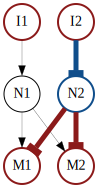

In [5]:
# The method for plotting will be simplified in next versions
G.plot(
    custom_edge_attr=cn.pl.edge_style(P, edge_var="edge_values_c0"),
    custom_vertex_attr=cn.pl.vertex_style(P, Gf, vertex_var="vertex_values_c0"),
)

In [6]:
import pandas as pd

from corneto.methods.carnival import get_result, get_selected_edges

V, E = get_result(P, Gf)
pd.DataFrame(V)

,V,value
0,I2,1.0
1,M1,1.0
2,N2,-1.0
3,N1,0.0
4,I1,1.0
5,M2,1.0
6,_s,1.0
7,_pert_c0,1.0
8,_meas_c0,0.0
9,_t,0.0


In [7]:
pd.DataFrame(E)

,E,value
0,"((I1), (N1))",0.0
1,"((N1), (M1))",0.0
2,"((N1), (M2))",0.0
3,"((I2), (N2))",-1.0
4,"((N2), (M2))",1.0
5,"((N2), (M1))",1.0
6,"((_s), (_pert_c0))",1.0
7,"((_pert_c0), (I1))",1.0
8,"((_pert_c0), (I2))",1.0
9,"((M1), (_meas_c0))",1.0


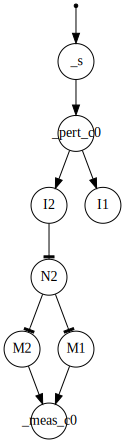

In [8]:
G_sol = Gf.edge_subgraph(get_selected_edges(P, Gf))
G_sol.plot()

## CARNIVAL with acyclic flow - single condition

In [9]:
exp_list = {"exp0": {"input": perturbations, "output": measurements}}
exp_list

{'exp0': {'input': {'I1': 1, 'I2': 1}, 'output': {'M1': 1, 'M2': 1}}}

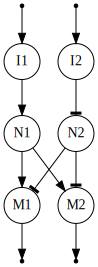

In [10]:
from corneto.methods import expand_graph_for_flows

G2 = G.copy()
G2 = expand_graph_for_flows(G2, exp_list)
G2.plot()

In [11]:
from corneto.methods import runCARNIVAL_AcyclicFlow

# We run the `standard` carnival problem. This interface is similar
# to the old R function https://saezlab.github.io/CARNIVAL/reference/runVanillaCarnival.html
P = runCARNIVAL_AcyclicFlow(G2, exp_list, solver="GUROBI")

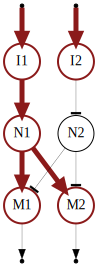

In [12]:
G2.plot(
    custom_edge_attr=cn.pl.edge_style(P, edge_var="edge_value"),
    custom_vertex_attr=cn.pl.vertex_style(P, G2, vertex_var="vertex_value"),
)

# CARNIVAL with acyclic flow - two conditions

Let's see how this works in case there are two conditions. 
Notice that the list of experiments contains two conditions. 

In [13]:
exp_list_multi = {
    "exp0": {"input": {"I1": 1}, "output": {"M1": 1}},
    "exp1": {"input": {"I2": 1}, "output": {"M1": 1, "M2": 1}},
}
exp_list_multi

{'exp0': {'input': {'I1': 1}, 'output': {'M1': 1}},
 'exp1': {'input': {'I2': 1}, 'output': {'M1': 1, 'M2': 1}}}

In [14]:
P_multi = runCARNIVAL_AcyclicFlow(G2, exp_list_multi, solver="GUROBI")

Now plot the solution graph for the first conditions (default)

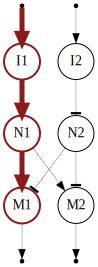

In [15]:
G2.plot(
    custom_edge_attr=cn.pl.edge_style(P_multi, edge_var="edge_value"),
    custom_vertex_attr=cn.pl.vertex_style(P_multi, G2, vertex_var="vertex_value"),
)

We can request to plot another conditions:

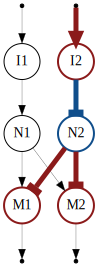

In [16]:
G2.plot(
    custom_edge_attr=cn.pl.edge_style(P_multi, edge_var="edge_value", condition=1),
    custom_vertex_attr=cn.pl.vertex_style(
        P_multi, G2, vertex_var="vertex_value", condition=1
    ),
)

## Limitation of single flow CARNIVAL

In [17]:
G_cross = cn.Graph.from_sif_tuples(
    [
        ("I1", 1, "A"),
        ("I2", 1, "B"),
        ("A", 1, "B"),
        ("B", 1, "C"),
        ("C", 1, "A"),
        ("A", 1, "O2"),
        ("B", 1, "O1"),
    ]
)
exp_list_cross = {
    "exp0": {"input": {"I1": 1, "I2": 0}, "output": {"O1": 1, "O2": 0}},
    "exp1": {"input": {"I1": 0, "I2": 1}, "output": {"O1": 0, "O2": 1}},
}

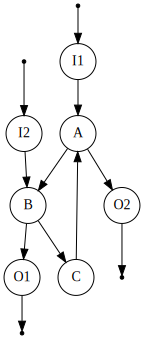

In [18]:
G_cross = expand_graph_for_flows(G_cross, exp_list_cross)
G_cross.plot()

In [19]:
P_cross = runCARNIVAL_AcyclicFlow(G_cross, exp_list_cross, solver="GUROBI")

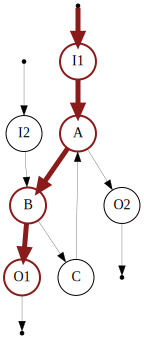

In [20]:
G_cross.plot(
    custom_edge_attr=cn.pl.edge_style(P_cross, edge_var="edge_value", condition=0),
    custom_vertex_attr=cn.pl.vertex_style(
        P_cross, G_cross, vertex_var="vertex_value", condition=0
    ),
)

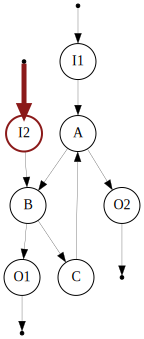

In [21]:
G_cross.plot(
    custom_edge_attr=cn.pl.edge_style(P_cross, edge_var="edge_value", condition=1),
    custom_vertex_attr=cn.pl.vertex_style(
        P_cross, G_cross, vertex_var="vertex_value", condition=1
    ),
)

## Let's check the Acyclic on flow

In [22]:
from corneto.methods import runCARNIVAL_Flow_Acyclic

In [23]:
P_cross = runCARNIVAL_Flow_Acyclic(G_cross, exp_list_cross, solver="GUROBI")

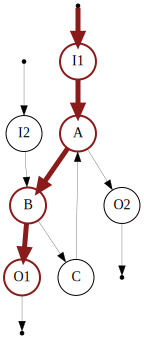

In [24]:
G_cross.plot(
    custom_edge_attr=cn.pl.edge_style(P_cross, edge_var="edge_value", condition=0),
    custom_vertex_attr=cn.pl.vertex_style(
        P_cross, G_cross, vertex_var="vertex_value", condition=0
    ),
)

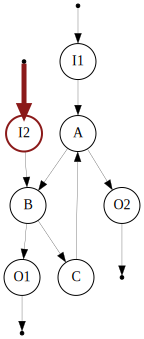

In [25]:
G_cross.plot(
    custom_edge_attr=cn.pl.edge_style(P_cross, edge_var="edge_value", condition=1),
    custom_vertex_attr=cn.pl.vertex_style(
        P_cross, G_cross, vertex_var="vertex_value", condition=1
    ),
)

## CARNIVAL with Acyclic signaling

`runCARNIVAL_Flow_Acyclic_Signal` applies the acyclic constraints on the signaling rather than on the flow. Thus, we can find a solution where the flow is not DAG, but the signaling is. 

In [26]:
from corneto.methods import runCARNIVAL_Flow_Acyclic_Signal

In [27]:
P_cross = runCARNIVAL_Flow_Acyclic_Signal(G_cross, exp_list_cross, solver="GUROBI")

In [28]:
cn.pl.edge_style(P_cross, edge_var="edge_value", condition=0)

{0: {'penwidth': '5', 'color': 'firebrick4'},
 1: {'penwidth': '0.25', 'color': 'black'},
 2: {'penwidth': '5', 'color': 'firebrick4'},
 3: {'penwidth': '0.25', 'color': 'black'},
 4: {'penwidth': '0.25', 'color': 'black'},
 5: {'penwidth': '0.25', 'color': 'black'},
 6: {'penwidth': '5', 'color': 'firebrick4'},
 7: {'penwidth': '0.25', 'color': 'black'},
 8: {'penwidth': '0.25', 'color': 'black'},
 9: {'penwidth': '5', 'color': 'firebrick4'},
 10: {'penwidth': '0.25', 'color': 'black'}}

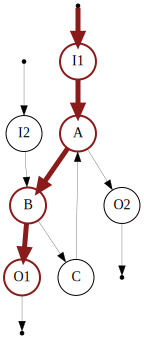

In [29]:
G_cross.plot(
    custom_edge_attr=cn.pl.edge_style(P_cross, edge_var="edge_value", condition=0),
    custom_vertex_attr=cn.pl.vertex_style(
        P_cross, G_cross, vertex_var="vertex_value", condition=0
    ),
)

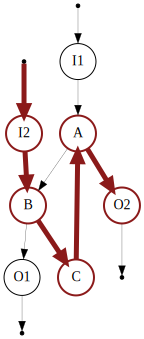

In [30]:
G_cross.plot(
    custom_edge_attr=cn.pl.edge_style(P_cross, edge_var="edge_value", condition=1),
    custom_vertex_attr=cn.pl.vertex_style(
        P_cross, G_cross, vertex_var="vertex_value", condition=1
    ),
)

## Sensitivity analysis

In this sensitivity analysis section we are looking of the effect of knocking out an edge at a time. 
This will show us how essential are individual edges to fit to data.  

First, lets defined the prior knowledge network and the input data.  
Note: we include some extra nodes, so that from A -> B there are now 2 paths: A -> B and A -> D -> B.


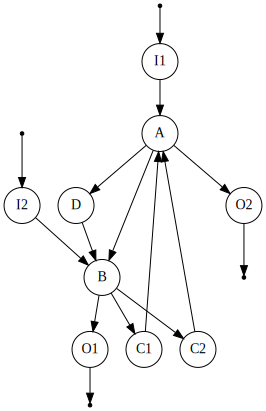

In [64]:
G_sens = cn.Graph.from_sif_tuples(
    [
        ("I1", 1, "A"),
        ("I2", 1, "B"),
        ("A", 1, "B"),
        ("B", 1, "C1"),
        ("B", 1, "C2"),
        ("C2", 1, "A"),
        ("C1", 1, "A"),
        ("A", 1, "D"),
        ("D", 1, "B"),
        ("A", 1, "O2"),
        ("B", 1, "O1"),
    ]
)
exp_list_cross = {
    "exp0": {"input": {"I1": 1, "I2": 0}, "output": {"O1": 1, "O2": 0}},
    "exp1": {"input": {"I1": 0, "I2": 1}, "output": {"O1": 0, "O2": 1}},
}
G_sens = expand_graph_for_flows(G_sens, exp_list_cross)
G_sens.plot()

In [65]:
P = runCARNIVAL_Flow_Acyclic_Signal(G_sens, exp_list_cross, solver="GUROBI",betaWeight=.1, verbosity=False)
[o.value for o in P.objectives]

[0.0, 0.0, 0.9]

the 3 numbers of the objectives are (1-2) the fitting error in the two conditions and (3) the penalty based on the edges with flows. 
Thus the data is perfectly captured by the model and there are 8 edges with flows.

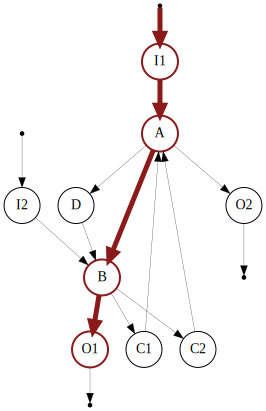

In [66]:
condition = 0
G_sens.plot(
    custom_edge_attr=cn.pl.edge_style(P, edge_var="edge_value", condition=condition),
    custom_vertex_attr=cn.pl.vertex_style(
        P, G_sens, vertex_var="vertex_value", condition=condition
    ),
)

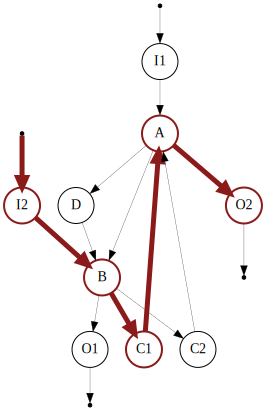

In [67]:
condition = 1
G_sens.plot(
    custom_edge_attr=cn.pl.edge_style(P, edge_var="edge_value", condition=condition),
    custom_vertex_attr=cn.pl.vertex_style(
        P, G_sens, vertex_var="vertex_value", condition=condition
    ),
)

Now, let's go 1-by-1 through the edges in the solution and knock them out to see if they can be replaced by alternative paths. 

We do this with soft constraints, so that we penalize the edges that are knocked out. This ensures that the problem definition is still feasible.

In [68]:
edge_cost = np.full(P.expressions.with_flow.value.shape, P.objectives[0].value)
for i in range(0,len(P.expressions.with_flow.value)):
    F = P.expressions.with_flow[i]
    P2 = P.add_objectives(10 * F, inplace=False)
    P2.solve(verbosity=False)
    print([o.value for o in P2.objectives])
    obj = sum([o.value for o in P2.objectives])
    edge_cost[i] = obj
    #print(str(i) + ": " + str(obj))

[0.0, 0.0, 0.9, 10.0]
[0.0, 0.0, 0.9, 10.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 0.9, 0.0]
[0.0, 0.0, 0.9, 0.0]
[0.0, 0.0, 0.9, 0.0]
[0.0, 0.0, 0.9, 0.0]
[0.0, 0.0, 0.9, 0.0]
[0.0, 0.0, 0.9, 0.0]
[0.0, 1.0, 0.5, 0.0]
[1.0, 0.0, 0.6000000000000001, 0.0]
[0.0, 1.0, 0.5, 0.0]
[1.0, 0.0, 0.6000000000000001, 0.0]
[0.0, 0.0, 0.9, 10.0]
[0.0, 0.0, 0.9, 10.0]


The output is a table, where the first 3 numbers are the fitting error and size penalty, while the last column is the penalty due to the inclusion of the strongly penalized edge.

Let's interpret the edges:  

- The first 2 and last 2 edges seem essential, since we could not find a better solution than including those edges.
    - `[0.0, 0.0, 0.9, 10.0]`

- The 3rd edges are not essentials: they can be removed. The fitting error are still 0 -> all data is captured by the model. The size penalty is increased by 0.1 (from 0.9 -> 1.0)
- the 4th - 9th edges are non-essential and there is an alternative paths with the same length. (they are not even included in the solution) 
- When the 10-12th edges are removed we see that the fitting error is increased to 1 in either the first or in the second condition.

In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
colormap = cm.RdYlBu_r


e_values = edge_cost
max_edge_width = 5
min_edge_width = 0.25
negative_color = "dodgerblue4"
positive_color = "firebrick4"
edge_attrs = dict()
for i, v in enumerate(e_values):
    if abs(v) > 0:
        edge_width = max_edge_width
    else:
        edge_width = min_edge_width
    edge_attrs[i] = {"penwidth": str(edge_width)}
    if e_values[i] > 0:
        edge_attrs[i]["color"] = mcolors.to_hex(colormap(v/edge_cost.max()))
    elif e_values[i] < 0:
        edge_attrs[i]["color"] = colormap(v/edge_cost.max())
    else:
        edge_attrs[i]["color"] = "black"

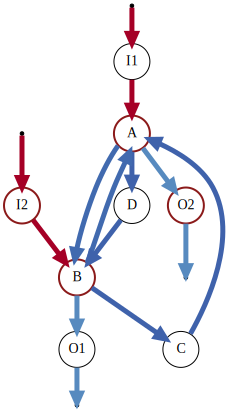

In [36]:
G_sens.plot(
    custom_edge_attr=edge_attrs,
    custom_vertex_attr=cn.pl.vertex_style(
        P, G_sens, vertex_var="vertex_value", condition=1
    ),
)

In [49]:
G_sens.E


((frozenset({'I1'}), frozenset({'A'})),
 (frozenset({'I2'}), frozenset({'B'})),
 (frozenset({'A'}), frozenset({'B'})),
 (frozenset({'B'}), frozenset({'C'})),
 (frozenset({'B'}), frozenset({'A'})),
 (frozenset({'C'}), frozenset({'A'})),
 (frozenset({'A'}), frozenset({'D'})),
 (frozenset({'D'}), frozenset({'B'})),
 (frozenset({'A'}), frozenset({'O2'})),
 (frozenset({'B'}), frozenset({'O1'})),
 (frozenset({'O2'}), frozenset()),
 (frozenset({'O1'}), frozenset()),
 (frozenset(), frozenset({'I1'})),
 (frozenset(), frozenset({'I2'})))

In [41]:
def run_edge_essentiality_screen(P,
                                KO_cost=10):
    """Compute edge essentiality upon knocking out edges 1-by-1.

    returns the objective function vector for each edge knockout. Note that the objective function vector
    is extended by the knock-out edge cost. 

    Parameters:
    ----------
    P : corneto.Problem
        The problem instance
    KO_cost : float
        The cost of knocking out an edge

    Returns:
    -------
    edge_cost : list
        A list of dictionaries containing the index of edge and the
        corresponding cost of knocking out the edge
    """
    edge_cost = {}
    for index, value in enumerate(P.expressions.with_flow.value):
        if value == 1:
            F = P.expressions.with_flow[index]
            P2 = P.add_objectives(KO_cost * F, inplace=False)
            P2.solve(verbosity=False)
            #print([o.value for o in P2.objectives])
            #obj = sum([o.value for o in P2.objectives])
            edge_cost[index] = [o.value for o in P2.objectives]
    return edge_cost
        #print(str(i) + ": " + str(obj))

In [75]:
essentiality = run_edge_essentiality_screen(P, KO_cost=10)
essentiality

{0: [0.0, 0.0, 0.9, 10.0],
 1: [0.0, 0.0, 0.9, 10.0],
 2: [0.0, 0.0, 1.0, 0.0],
 3: [0.0, 0.0, 0.9, 0.0],
 4: [0.0, 0.0, 0.9, 0.0],
 5: [0.0, 0.0, 0.9, 0.0],
 6: [0.0, 0.0, 0.9, 0.0],
 7: [0.0, 0.0, 0.9, 0.0],
 8: [0.0, 0.0, 0.9, 0.0],
 9: [0.0, 1.0, 0.5, 0.0],
 10: [1.0, 0.0, 0.6000000000000001, 0.0],
 11: [0.0, 1.0, 0.5, 0.0],
 12: [1.0, 0.0, 0.6000000000000001, 0.0],
 13: [0.0, 0.0, 0.9, 10.0],
 14: [0.0, 0.0, 0.9, 10.0]}

In [79]:
# Lets redesign this function: 

# what we want is an overview of edge essentiality. There are the following cathegories:

# - essential: the removal of the edge would result in an infeasible solution (firebrick)
# - data_essential: the removal of the edge would compromise the fitting to the data (orange)
# - substitutable: the removal of the edge would not compromise the fitting to the data (blue)

def edge_essentiality_attr(G, essentiality, type = "overview"):
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    colormap_total_cost = cm.RdYlBu_r
    colormap_fit_cost =  cm.RdYlBu_r
    unsolvability_color = "firebrick"
    ESSENTIAL = 1
    data_essential_color = "orange"
    DATA_ESSENTIAL = 2
    substitutable_color = "blue"
    SUBSTITUTABLE = 3

    edge_value = np.full(len(G_sens.E), 0.0)
    edge_color = []

    if type == "overview":
        # Compute the total cost of knocking out an edge
        for key, value in essentiality.items():
            if value[-1] > 0:
                edge_value[key] = ESSENTIAL
            elif sum(value[:-2]) > 0:
                edge_value[key] = DATA_ESSENTIAL
            else:
                edge_value[key] = SUBSTITUTABLE
        
        for e in edge_value:
            if e == ESSENTIAL:
                edge_color.append(unsolvability_color)
            elif e == DATA_ESSENTIAL:
                edge_color.append(data_essential_color)
            elif e == SUBSTITUTABLE:
                edge_color.append(substitutable_color)
            else:
                edge_color.append('black')

    elif type == "total_cost":
        # Compute the total cost of knocking out an edge
        for key, value in essentiality.items():
            edge_value[key] = sum(value)
        
        # here we use a continuous color scheme to represent the edge cost
        scaled_edge_value = (edge_value-edge_value.min())/(edge_value.max()-edge_value.min())
        edge_color = [mcolors.to_hex(v) for v in colormap_total_cost(scaled_edge_value)]
    elif type == "fit_cost":
        # higlight edges that would result in a worse fit in terms of fitting the data
        for key, value in essentiality.items():
            # TODO: here we assume that the fit is everything except the last two objectives. 
            # probably we could get this info from ProblemDef or experiment. 
            edge_value[key] = sum(value[:-2])
        scaled_edge_value = (edge_value-edge_value.min())/(edge_value.max()-edge_value.min())
        edge_color = [mcolors.to_hex(v) for v in colormap_fit_cost(scaled_edge_value)]

    elif type == "solvability":
        # highlight edges that would result in an unsolvable problem
        for key, value in essentiality.items():
            # TODO: here we assume that essentiality penalty is in the last objective
            edge_value[key] = value[-1]
        edge_color = [unsolvability_color if value > 0 else 'black' for value in edge_value]            

    max_edge_width = 5
    min_edge_width = 1
    edge_attrs = dict()
    #print(edge_value)
    #print(edge_color)
    for i, v in enumerate(edge_value):
        if abs(v) > 0:
            edge_width = max_edge_width
        else:
            edge_width = min_edge_width
        edge_attrs[i] = {"penwidth": str(edge_width)}
        if v > 0:
            edge_attrs[i]["color"] = edge_color[i]
        else:
            edge_attrs[i]["color"] = "black"
    return(edge_attrs)

[1. 1. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 1. 1.]
['firebrick', 'firebrick', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'orange', 'orange', 'orange', 'orange', 'firebrick', 'firebrick']


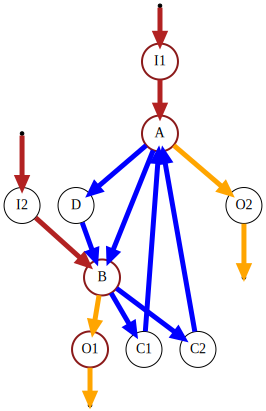

In [77]:
edge_attr = edge_essentiality_attr(G_sens, essentiality, type = "overview")
G_sens.plot(
        custom_edge_attr=edge_attr,
        custom_vertex_attr=cn.pl.vertex_style(
            P,G_sens, vertex_var="vertex_value", condition=0
        )
    )

### Total cost change on the network

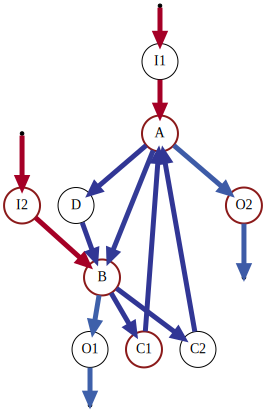

In [83]:
edge_attr = edge_essentiality_attr(G_sens, essentiality, type = "total_cost")
G_sens.plot(
        custom_edge_attr=edge_attr,
        custom_vertex_attr=cn.pl.vertex_style(
            P, G_sens, vertex_var="vertex_value", condition=1
        )
    )

### Fit Cost
The elimination of which nodes would lead to increased fitting error?

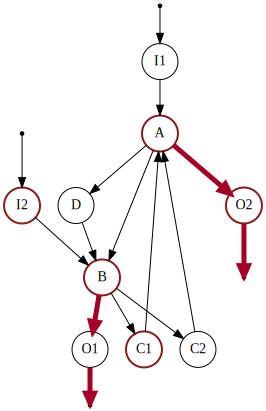

In [82]:
edge_attr = edge_essentiality_attr(G_sens, essentiality, type = "fit_cost")
G_sens.plot(
        custom_edge_attr=edge_attr,
        custom_vertex_attr=cn.pl.vertex_style(
            P, G_sens, vertex_var="vertex_value", condition=1
        )
    )

### Solvability issue
The removal of which edge would transform the problem to infisible?

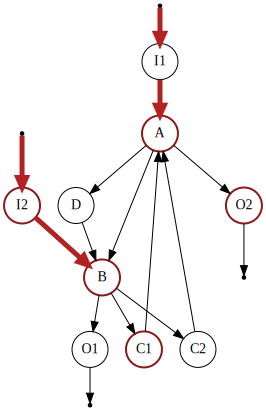

In [84]:
edge_attr = edge_essentiality_attr(G_sens, essentiality, type = "solvability")
G_sens.plot(
        custom_edge_attr=edge_attr,
        custom_vertex_attr=cn.pl.vertex_style(
            P, G_sens, vertex_var="vertex_value", condition=1
        )
    )